In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
from tqdm import tnrange
from tqdm import trange

In [2]:
%matplotlib inline
from collections import OrderedDict
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import random as rand
import math
from math import exp
from mpl_toolkits.mplot3d import Axes3D as plt3d
import numpy as np
import time
import numpy as np
from scipy.integrate import quad as integrate
#fig, ax = plt.subplots(figsize=(20,10))

In [4]:
dt = 2.9116223400000000865 #average time step
#qualitative: for intensity at 100: 100*np.exp(-(1/500)*(t-60)**2)
def pulse(t):
    #guassian form
    return 100*np.exp(-(1/500)*(t-60)**2)

total_pulse_area = integrate(pulse, 0, 120)[0]

def distance(atom1, atom2):
    #gives distance between atom
    return ((atom1.x - atom2.x)**2 + (atom1.y - atom2.y)**2)**(1/2)

class Ensemble():
    #basically a numpy array containing objects but with more functionalities
    def __init__(self, N_I2, N_H2, lim = (20, 20), T = 300):
        self.configuration = np.array([])
        self.lim = lim
        self.T = T
        self.B = ((1.38064852e-23) * T)**-1
        #for i in range(N):
        #    self.Spawn(N)
        self.Spawn(N_I2, N_H2)
        #during sampling, any accepted configuration will have its energy sotred in this list.
        self.configuration_total_energies = np.array([self.Energy_Total()])
    def __getitem__(self, key):
        return self.configuration[key]
    
    def __setitem__(self, key, value):
        self.configuration[key] = value

    def append(self, value):
        self.configuration = np.append(self.configuration, value)
    
    def Distance(self, atom1, atom2):
    #gives distance between atom
        return ((atom1.x - atom2.x)**2 + (atom1.y - atom2.y)**2)**(1/2)
    
    def Check_VDW_Collision(self, testAtom, atom, k = 1):
        '''
        Parameters: k is a scaling factor for collision
        returns True if there exists a atom within testAtom's vdw radius
        '''
        return self.Distance(testAtom, atom) <= (testAtom.vdw + atom.vdw)*k
    
    def Spawn_deprecated(self, N):
        #deprecated
        for attempt in range(N+50):
            testAtom = Atom(rand.uniform(0, self.lim[0]), rand.uniform(0, self.lim[1]))
            if not any((testAtom.x, testAtom.y) == (atom.x, atom.y) or self.Check_VDW_Collision(testAtom, atom) for atom in self.configuration):
                self.configuration = np.append(self.configuration, testAtom)
                #print("INITIAL:", (testAtom.x, testAtom.y))
                break

        else:
            print("Failed to spawn!")
            return None
        return None
    
    def Spawn_Diatomic(self, N):
        pos1 = np.array((rand.uniform(0+10, self.lim[0]-10), rand.uniform(0+10, self.lim[1]-10)))
        dx = rand.uniform(-2.666, 2.666)
        pos2 = np.array((pos1[0]+dx,(2.666**2-(dx)**2)**0.5+pos1[1]))
        
        
        self.configuration = np.append(self.configuration, I2({0: pos1, 1: pos2}))
    
    def Spawn(self, N_I2, N_H2):
        spawn_tol = 2 #temporary variable to restrict spawn area
        for i in range(N_I2):
            pos1 = np.array((rand.uniform(0+spawn_tol, self.lim[0]-spawn_tol), rand.uniform(0+spawn_tol, self.lim[1]-spawn_tol)))
            dx = rand.uniform(-2.666, 2.666)
            pos2 = np.array((pos1[0]+dx,(2.666**2-(dx)**2)**0.5+pos1[1]))
            self.configuration = np.append(self.configuration, I2({0: pos1, 1: pos2}))
        
        for i in range(N_H2):
            pos1 = np.array((rand.uniform(0+spawn_tol, self.lim[0]-spawn_tol), rand.uniform(0+spawn_tol, self.lim[1]-spawn_tol)))
            dx = rand.uniform(-0.74, 0.74)
            pos2 = np.array((pos1[0]+dx,(0.74**2-(dx)**2)**0.5+pos1[1]))
            self.configuration = np.append(self.configuration, H2({0: pos1, 1: pos2}))
    
    def Update_Energy(self):
        #pairwise calculation & i != j
        e0 = 8.85418782e-12 #permititivy of free space in m^-3 kg^-1 s^4 Amphere^2
        for i in self.configuration:
            i.V = 0
            for j in self.configuration:
                if i == j:
                    continue
                d = np.linalg.norm(i.getPosc() - j.getPosc())
                #Lorentz-Berthelot mixing rule
                si = (i.sigma + j.sigma)/2 
                ep = (i.epsilon * j.epsilon)**1/2
                i.V += ((4 * ep * ((si/d)**12 - (si/d)**6))) #joules, LJ
                d *= 1e-10
                i.V += ((i.charge*j.charge)/(4*math.pi*e0*d)) #joules, electrostatics
                
    
    def Energy_Total(self):
        self.Update_Energy()
        return sum(atom.V for atom in self.configuration)
    
    def AcceptanceRule(self, Uo, Ut):
        #Canonical acceptance function
        try:
            return min(1, exp((-1)*self.B*(Ut - Uo)))
        except OverflowError:
            print("Overflow error! - Ensemble.AcceptanceRule()")
            return 1
    
    def Cycle(self, time_pulse, time_total):
        #check dissociation
        for particle in self.configuration:
            chance = rand.uniform(0, 1)
            if isinstance(particle, I2) and chance <= (integrate(pulse, time_pulse, time_pulse+dt)[0]/total_pulse_area):
                print("Dissociation!")
                print("Integral chance:", (integrate(pulse, time_pulse, time_pulse+dt)[0]/total_pulse_area)*100, "%")
                print("Random chance:", chance * 100, "%")
                print("Time pulse:",time_pulse)
                print("Time total:", time_total)
                print()
                particle.Dissociate(self, self.lim)
                
        #check for recombination
        for particle in self.configuration:
            if isinstance(particle, Iodide):
                for otherParticle in self.configuration:
                    if otherParticle != particle and isinstance(otherParticle, Iodide):
                        #if distance between two atoms are less than/equal to I2 bond length, recombine
                        #assume ideal gas and elastic so Iodide atoms have enough kinetic energy
                        #for recombination since their velocity should be from when they dissociated
                        d = ((otherParticle.pos[0] - particle.pos[0])**2 + (otherParticle.pos[1] - particle.pos[1])**2)**0.5
                        if d <= 2.666:
                            
                        
        particle = self.configuration[rand.randint(0, len(self.configuration) -1)] #select random particle
        pos_old = particle.pos
        
        
        if isinstance(particle, Diatomic):
            if rand.uniform(0, 1.0) < 0.5: #50% chance for translation
                #translation
                #print("Translation")
                pos_trial = particle.Translate(self.configuration, self.lim)
            else:
                #rotation
                #print("Rotation")
                pos_trial = particle.Rotate(self.configuration, self.lim)
        else:
            pos_trial = particle.Translate(self.configuration, self.lim)
            
        Uo = self.Energy_Total() # Uo is total system of OLD/current configuration
        particle.pos = pos_trial 
        Ut = self.Energy_Total()
        if rand.uniform(0,1) < self.AcceptanceRule(Uo, Ut):
            #accept Ut
            self.configuration_total_energies = np.append(self.configuration_total_energies, Ut)
            return
        else:
            #reject Ut
            particle.pos = pos_old
            #could it be double-counting if this is uncommented?
            #self.configuration_total_energies = np.append(self.configuration_total_energies, Uo)
    
    def Average(self):
        #takes in an array containing energies corresponding to a sampled configuration
        #evaluates average energy by probaility weighting
        numerator = 0
        denominator = 0
        for i in range(len(self.configuration_total_energies)):
            numerator += (self.configuration_total_energies[i] * exp((-1)*self.B*self.configuration_total_energies[i]))
            denominator += exp((-1)*self.B*self.configuration_total_energies[i])
        return numerator/denominator

    def Plot(self, title = ""):
        fig, ax = plt.subplots(figsize=(20,10))
        for atom in self.configuration:
            if isinstance(atom, Diatomic):
                plt.scatter(atom.pos[0][0], atom.pos[0][1], c = "black", s = 5)
                plt.scatter(atom.pos[1][0], atom.pos[1][1], c = "red", s = 10)
                plt.plot([atom.pos[0][0], atom.pos[1][0]], [atom.pos[0][1], atom.pos[1][1]])
                ax.add_artist(plt.Circle((atom.pos[0][0], atom.pos[0][1]), atom.vdw, fill = False))
                ax.add_artist(plt.Circle((atom.pos[1][0], atom.pos[1][1]), atom.vdw, fill = False))
            else:
                plt.scatter(atom.pos[0], atom.pos[1], c = "black", s = 1)
                ax.add_artist(plt.Circle((atom.pos[0], atom.pos[1]), atom.vdw, fill = False))
        plt.xlim([0, self.lim[0]])
        plt.ylim([0, self.lim[1]])
        plt.title(title)
        ax.set_aspect('equal')

class Atom():
    def __init__(self, pos, sigma, epsilon, vdw, mass, charge):
        '''
        '''
        #default parameters = argon
        self.kb = 1.38064852e-23
        self.mass = mass
        self.vdw = vdw #angstrom...just random value of previous proposed
        self.sigma = sigma # mourits and rummens. Can. J. Chem. 55, 3007 (1977)
        self.epsilon = epsilon #joules, mourits and rummens. Can. J. Chem. 55, 3007 (1977)
        self.V = 0
        self.pos = pos #np.array([x,y]) #center position, which is the same as position
        self.charge = 1.60217662e-19 * charge
        #self.x = x
        #self.y = y
    
    def getPosc(self):
        #redundant but creating this method so that certain lines of codes are universal regardless of
        #Atom or Diatomic type objects.
        return self.pos

class Iodide(Atom):
    def __init__(self, pos):
        self.kb = 1.38064852e-23
        #initialized with argon parameters...will change later
        Atom.__init__(self, pos, sigma = 3.465, epsilon = 113.5*self.kb, vdw = 1.98, mass = 2.1072981168e-25, charge = 0)
    
    def Translate(self, configuration, lim):
        low = -0.01
        high = 0.01
        pos_trial = self.pos + [rand.uniform(low, high), rand.uniform(low, high)]
        if pos_trial[0] < 0:
            pos_trial[0] = abs(pos_trial[0] + lim[0])
        elif pos_trial[0] > lim[0]:
            pos_trial[0] = pos_trial[0] - lim[0]
        if pos_trial[1] < 0:
            pos_trial[1] = abs(pos_trial[1] + lim[1])
        elif pos_trial[1] > lim[1]:
            pos_trial[1] = pos_trial[1] - lim[1]
        return pos_trial
        
class Diatomic():
    def __init__(self, pos, sigma, epsilon, bond_length, vdw, mass, charge):
        #default parameters = I2
        #I2 bond length = 2.666 A
        self.kb = 1.38064852e-23
        self.sigma = sigma 
        self.epsilon = epsilon
        self.bond_length = bond_length #Angstrom
        self.vdw = vdw
        self.pos = pos #dictionary. key = atom, value = np.array([x_coord, y_coord])
        self.V = 0 #potential energy
        self.mass = mass
        self.charge = 1.60217662e-19 * charge
    
    def getPosc(self):
        #return center position coordinates
        return np.array([(self.pos[0][0] + self.pos[1][0])/2,(self.pos[0][1] + self.pos[1][1])/2]) 
    
    def __ccw(self, A,B,C):
        # source: https://stackoverflow.com/questions/70528/why-are-pythons-private-methods-not-actually-private
        return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

    def __If_Intersect(self, A,B,C,D):
        # source: https://stackoverflow.com/questions/70528/why-are-pythons-private-methods-not-actually-private
        # Return true if line segments AB and CD intersect
        return self.__ccw(A,C,D) != self.__ccw(B,C,D) and self.__ccw(A,B,C) != self.__ccw(A,B,D)
    
    
    def __If_Collision(self, pos_test, configuration):
        #PROBAAABBLY dont need to check collision bc if overlap then r = 0 and the probability acceptance ratio is infinity
        #and so the translation will never be accepeted
        #if any(np.array_equal(self.pos[0], otherParticle.pos[0]) for otherParticle in configuration if otherParticle is not self) or \
        #    any(np.array_equal(self.pos[1], otherParticle.pos[1]) for otherParticle in configuration if otherParticle is not self):
        #    print("Collision! Atom overlap")
        #    return True
        if any(self.__If_Intersect(self.pos[0], self.pos[1], otherParticle.pos[0], otherParticle.pos[1]) \
               for otherParticle in configuration if otherParticle is not self and isinstance(otherParticle, Diatomic)):
            print("Collision! Bond overlap")
            return True
        return False
    
    def Translate(self, configuration, lim):
        #return trial coordinates after translation. does not update self's coordinates
        low = -0.01
        high = 0.01
        dx = rand.uniform(low, high)
        dy = rand.uniform(low, high)
        pos_trial = {0: self.pos[0] + [dx, dy], 1: self.pos[1] + [dx, dy]}
        attempts = 0
        while self.__If_Collision(pos_trial, configuration) or \
                any(pos_trial[0] > lim) or any(pos_trial[1] > lim) or \
                any(pos_trial[0] < [0,0]) or any(pos_trial[1] < [0,0]) or attempts < 100:
            #print("Rerolling translation coordinates")
            dx = rand.uniform(low, high)
            dy = rand.uniform(low, high)
            pos_trial = {0: self.pos[0] + [dx, dy], 1: self.pos[1] + [dx, dy]}
            attempts += 1
        return pos_trial
        
    def Rotate(self, configuration, lim):
        #returns trial coordinates after rotation. does not update self's coordinates
        cx = (self.pos[0][0] + self.pos[1][0])/2 #center x
        cy = (self.pos[0][1] + self.pos[1][1])/2 #center y
        th = rand.uniform(0, 2*math.pi) #random theta
        
        #trial x coordinate for atom 1
        x1t = ((self.pos[0][0] - cx) * math.cos(th) + (self.pos[0][1] - cy) * math.sin(th) ) + cx 
        #trial y coordinate for atom 1
        y1t = (-(self.pos[0][0] - cx) * math.sin(th) + (self.pos[0][1] - cy) * math.cos(th) ) + cy 
        
        #trial x coordinate for atom 2
        x2t = ((self.pos[1][0] - cx) * math.cos(th) + (self.pos[1][1] - cy) * math.sin(th) ) + cx 
        #trial y coordinate for atom 2
        y2t = (-(self.pos[1][0] - cx) * math.sin(th) + (self.pos[1][1] - cy) * math.cos(th) ) + cy 
        
        pos_trial = {0: np.array([x1t, y1t]), 1: np.array([x2t, y2t])}
        attempts = 0
        while self.__If_Collision(pos_trial, configuration) or \
                any(pos_trial[0] + [self.vdw, self.vdw] > lim) or any(pos_trial[1] + [self.vdw,  self.vdw] > lim) or \
                any(pos_trial[0] < [0,0]) or any(pos_trial[1] < [0,0]) or attempts < 100:
            #print("Rerolling rotation")
            th = rand.uniform(0, 2*math.pi) #random theta
        
            #trial x coordinate for atom 1
            x1t = ((self.pos[0][0] - cx) * math.cos(th) + (self.pos[0][1] - cy) * math.sin(th) ) + cx 
            #trial y coordinate for atom 1
            y1t = (-(self.pos[0][0] - cx) * math.sin(th) + (self.pos[0][1] - cy) * math.cos(th) ) + cy 

            #trial x coordinate for atom 2
            x2t = ((self.pos[1][0] - cx) * math.cos(th) + (self.pos[1][1] - cy) * math.sin(th) ) + cx 
            #trial y coordinate for atom 2
            y2t = (-(self.pos[1][0] - cx) * math.sin(th) + (self.pos[1][1] - cy) * math.cos(th) ) + cy 

            pos_trial = {0: np.array([x1t, y1t]), 1: np.array([x2t, y2t])}
            attempts += 1
        return pos_trial
    


class H2(Diatomic):
    def __init__(self, pos):
        self.kb = 1.38064852e-23
        #LJ parameters from: Michels, Graaf, Seldam 1960 physica 26 393-408
        #suggested LJ parameters as "best" agreement, but still off from experimental.
        #sigma converted from reported units to Angstroms
        Diatomic.__init__(self, pos, sigma = 2.953, epsilon = 36.7 * self.kb, bond_length = 0.74, vdw = 1.20, \
                          mass = 3.34711e-27, charge = 0)
        
class HI(Diatomic):
    def __init__(self, pos):
        self.kb = 1.38064852e-23
        #vdw is average of H and I for now..will change later. vdw is just to make plot look better a bit better
        #pos 1 is H, pos 2 is I
        Diatomic.__init__(self, pos, sigma = 4.080, epsilon = 333.6 * self.kb, bond_length = 1.609, vdw = 1.59, \
                          mass = 2.12403e-25, charge = 0)


class I2(Diatomic):
    def __init__(self, pos):
        #sigma & epsilon values: Mourits and Rummens. Can. J. Chem. 55, 3007 (1977)
        self.kb = 1.38064852e-23
        Diatomic.__init__(self, pos, sigma = 4.630, epsilon = 577.4 * self.kb, bond_length = 2.666, vdw = 1.98, \
                          mass = 4.2145962337e-25, charge = 0)
        
    def Dissociate(self, system, lim):
        for particle in system.configuration:
            if isinstance(particle, H2):
                #add tolerance
                m1 = (particle.pos[0][1] - self.pos[0][1])/(self.pos[1][1]-self.pos[0][1])
                m2 = (particle.pos[1][1] - self.pos[0][1])/(self.pos[1][1]-self.pos[0][1])
                b1 = (particle.pos[0][0] - self.pos[0][0])/(self.pos[1][0]-self.pos[0][0])
                b2 = (particle.pos[1][0] - self.pos[0][0])/(self.pos[1][0]-self.pos[0][0])
                tol = 1.98 #vdw radius...a very poor approximation since nuceli must collide, but how sparse the
                            #system is, its a good idea to make the tolerance a little bit higher
                if (m1-tol <= b1 <= m1+tol) or (m2-tol <= b2 <= m2+tol):
                    #if H2 center is colinear with I2
                    H_1 = particle.pos[0] #hydrogen 1
                    H_2 = particle.pos[1] #hydrogen 2

                    d = (H_1 - H_2)/np.linalg.norm(H_1-H_2) #normalized vector distance between the two hydrogens
                    #0: H, 1: I
                    system.configuration = np.append(system.configuration, (HI({0:H_1, 1:H_1+d*1.609})))
                    system.configuration = np.append(system.configuration, (HI({0:H_2, 1:H_2+d*-1.609})))
                    system.configuration = np.delete(system.configuration, np.argwhere(system.configuration == particle))
                    system.configuration = np.delete(system.configuration, np.argwhere(system.configuration == self))
                    print("Hit H2!")
                    return
        else:
            #if no colinear H2, reaction does not proceed and I radical is formed
            m = (self.pos[0][1] - self.pos[1][1])/(self.pos[0][0] - self.pos[1][0])
            b = self.pos[0][1]-(self.pos[0][0]*m)
            #y = mx + b
            #check case intersection y = 0, x = -b/m
            xt = -b/m
            if 0 <= xt <= lim[0]:
                x1 = xt
                y1 = 0
                
                #check every other case to determine other radicals coordinates
                yt = b
                if 0 <= yt <= lim[1]:
                    x2 = 0
                    y2 = yt
                yt = m*lim[0] + b
                if 0 <= yt <= lim[1]:
                    x2 = lim[0]
                    y2 = yt
                xt = (lim[1]-b)/m
                if 0 <= xt <= lim[0]:
                    x2 = xt
                    y2 = lim[1]
                
            
            #check case intersection x = 0, y = b
            yt = b
            if 0 <= yt <= lim[1]:
                x1 = 0
                y1 = yt
                
                xt = -b/m
                if 0 <= xt <= lim[0]:
                    x2 = xt
                    y2 = 0
                yt = m*lim[0] + b
                if 0 <= yt <= lim[1]:
                    x2 = lim[0]
                    y2 = yt
                xt = (lim[1]-b)/m
                if 0 <= xt <= lim[0]:
                    x2 = xt
                    y2 = lim[1]
            
            #check case intersection x = lim
            yt = m*lim[0] + b
            if 0 <= yt <= lim[1]:
                x1 = lim[0]
                y1 = yt
                
                yt = b
                if 0 <= yt <= lim[1]:
                    x2 = 0
                    y2 = yt
                xt = -b/m
                if 0 <= xt <= lim[0]:
                    x2 = xt
                    y2 = 0
                xt = (lim[1]-b)/m
                if 0 <= xt <= lim[0]:
                    x2 = xt
                    y2 = lim[1]
                
            #check case intersection y = lim
            xt = (lim[1]-b)/m
            if 0 <= xt <= lim[0]:
                x1 = xt
                y1 = lim[1]
                
                yt = b
                if 0 <= yt <= lim[1]:
                    x2 = 0
                    y2 = yt
                yt = m*lim[0] + b
                if 0 <= yt <= lim[1]:
                    x2 = lim[0]
                    y2 = yt
                xt = -b/m
                if 0 <= xt <= lim[0]:
                    x2 = xt
                    y2 = 0
            
            system.configuration = np.append(system.configuration, Iodide(np.array([x1, y1])))
            system.configuration = np.append(system.configuration, Iodide(np.array([x2, y2])))
            system.configuration = np.delete(system.configuration, np.argwhere(system.configuration == self))
            print("Formed 2I!")
        
        
def run(ncyc, N = 1, lim = (20, 20), T = 300, ensemble = None, animation = False, dframe = 0.001):
    #initialize system
    time_total = 0 #total "time" of the system
    time_pulse = 0 #time of the pulse
    if ensemble == None:
        ensemble = Ensemble(N, lim, T)
        ensemble.Plot("Initial Configuration")
    else:
        ensemble.Plot("Initial Configuration")
    #start simulation
    y = [ensemble.Energy_Total()]
    start_time = time.time()
    for i in trange(ncyc):
        ensemble.Cycle(time_pulse = time_pulse, time_total = time_total)
        y.append(ensemble.Energy_Total())
        time_total += dt
        if time_pulse + dt > 120:
            time_pulse += dt - 120
        else:
            time_pulse += dt
        if animation:
            fig = ensemble.Plot()
            clear_output(wait=True) # Clear output for dynamic display
            display(fig)            # Reset display
            fig.clear()             # Prevent overlapping and layered plots
            time.sleep(dframe)
    print("Elapsed time:", time.time() - start_time, "(s)")
    print("Initial energy:", y[0], "(J)")
    print("Final energy:", y[-1], "(J)")
    print("Average energy:", ensemble.Average(),"(J)")

    ensemble.Plot("Final Configuration")
    x = range(0, len(y))
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(x,y)
    plt.xlim([0, ncyc])
    plt.ylim([min(y), max(y)])
    plt.title("Total Energy vs. Cycle")
    return ensemble





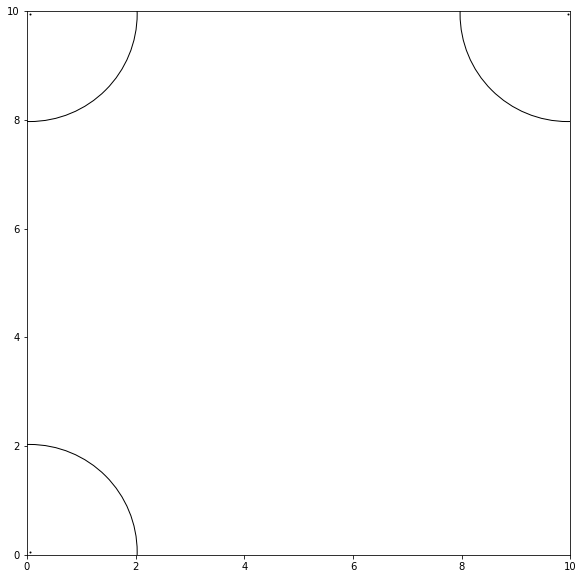

In [42]:
system = Ensemble(0, 0, lim = (10,10))
#system.configuration = np.append(system.configuration, Iodide(np.array([20, 10])))
system.configuration = np.append(system.configuration, Iodide(np.array([9.95,9.95])))
system.configuration = np.append(system.configuration, Iodide(np.array([0.05,0.05])))
system.configuration = np.append(system.configuration, Iodide(np.array([0.05,9.95])))
system.Plot()

100%|██████████| 100000/100000 [00:23<00:00, 4213.56it/s]


Elapsed time: 23.73499298095703 (s)
Initial energy: -3.8302512250209137e-44 (J)
Final energy: 9.247307161163643e-40 (J)
Average energy: 6.527706145776832e-24 (J)


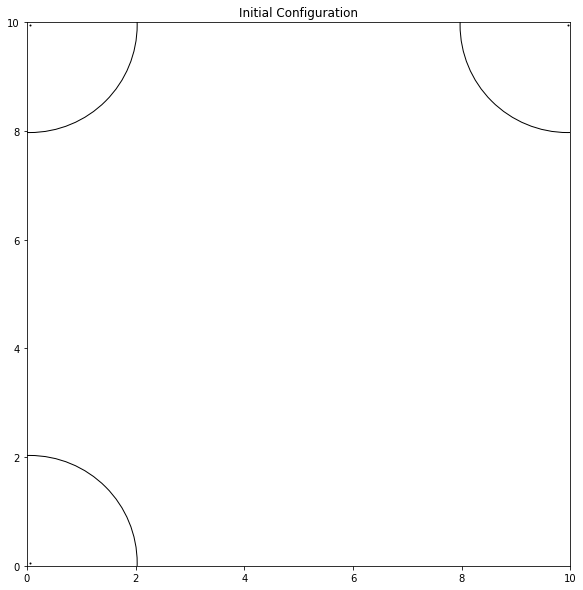

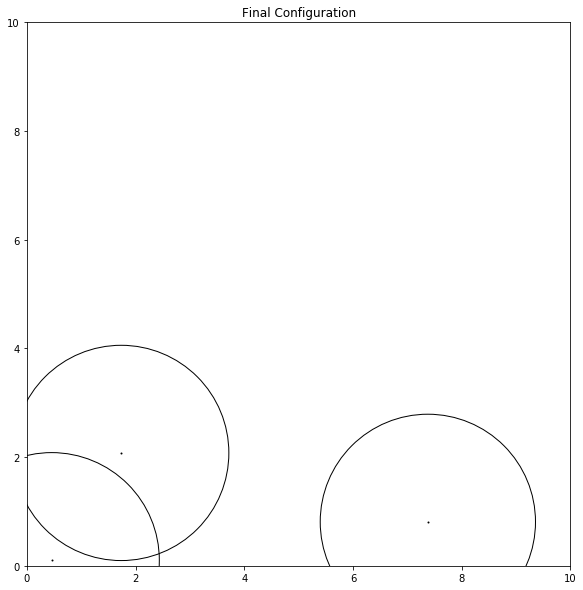

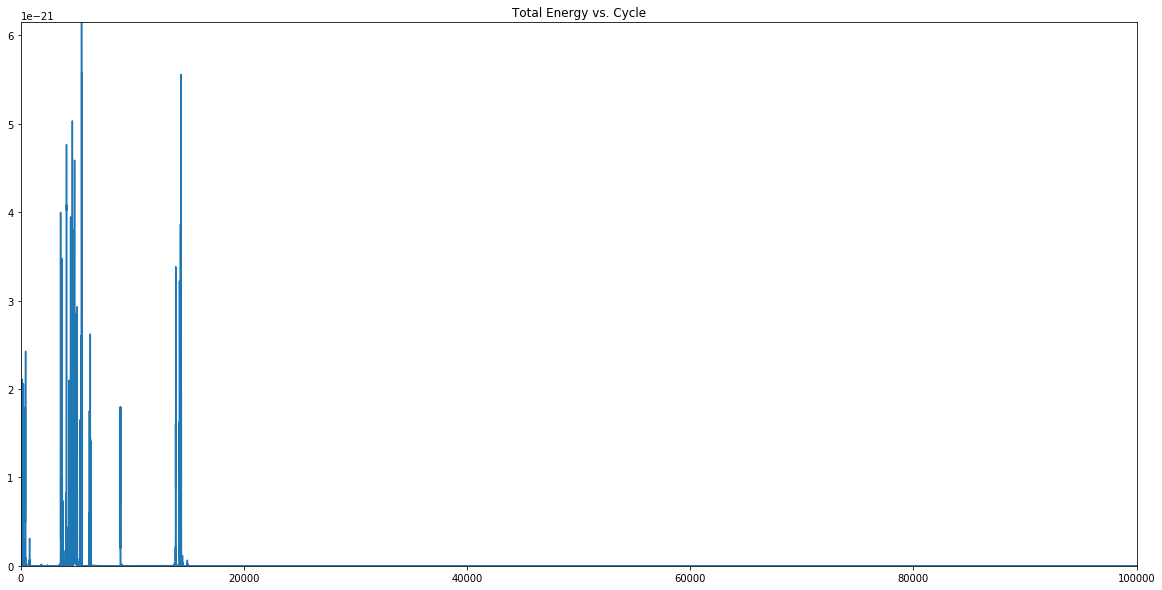

In [43]:
run(ncyc = 100000, ensemble = system)

6.147548670709983e-21

# GUASSIAN

In [ ]:

def pulse(t):
    #guassian form
    return np.exp(-(1/1500)*t**2)
total = integrate(pulse, -120, 120)[0]
integrate(pulse, -55, 23)[0]/total

In [ ]:
class Animal():
    def __init__(self, a):
        self.a = a
        self.b = 1
        self.c = 1
        self.e = 55
    def return_c(self):
        return self.c
    def holo(self):
        self.e += 100
    
class Dog(Animal):
    def __init__(self, a):
        Animal.__init__(self, a)
bob = Dog(5)

In [ ]:
bob.e
bob.holo()
bob.e
type(bob)

In [ ]:
issubclass(type(bob), Diatomic)

In [ ]:
type(bob)

In [ ]:
isinstance(bob, Dog)

In [ ]:
if 5 == 5 == 5:
    print("a")

In [ ]:
arr = [1,2,3]

def a(arr2):
    arr2.append(5)

print(arr)
a(arr)
print(arr)

In [ ]:
arr = np.array([1,2,3])
def a(arr2):
    arr2[0] += 54
a(arr)
arr

In [ ]:
def pulse(t):
    #guassian form
    return 100*np.exp(-(1/500)*(t-60)**2)

total_pulse_area = integrate(pulse, 0, 120)[0]

In [ ]:
a = np.arange(0, 120, dt)
for t in a:
    print((integrate(pulse, t, t+dt)[0]/total_pulse_area) * 100)

In [ ]:
t = 119
if t + dt > 120:
    t += dt - 120
t